In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227136 sha256=2c9c0f9d8437d9c0cca0ac331325207b10aba631f44897583860846cbc156140
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


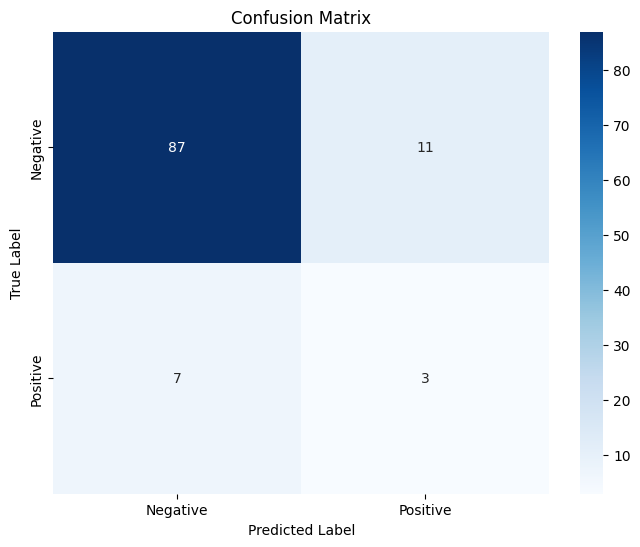

Accuracy: 0.8333333333333334


In [7]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
import fasttext
import numpy as np
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """ Lowercase, remove punctuation, numbers, and stopwords, and apply lemmatization. """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

# Mount Google Drive to access files
drive.mount('/content/drive')

# Load and preprocess data
data_path = '/content/drive/My Drive/experiment/example_hotel_review.csv'
reviews_df = pd.read_csv(data_path)
reviews_df['Processed_Reviews'] = reviews_df['Positive_Review'].str.cat(reviews_df['Negative_Review'], sep=" ").apply(preprocess_text)

# Save processed reviews to a text file for FastText training
reviews_path = '/content/drive/My Drive/experiment/reviews.txt'
reviews_df['Processed_Reviews'].to_csv(reviews_path, index=False, header=False)

# Train FastText model
ft_model = fasttext.train_unsupervised(reviews_path, model='skipgram')
ft_model.save_model('/content/drive/My Drive/experiment/fasttext_model.bin')

# Load FastText model
fasttext_model = fasttext.load_model('/content/drive/My Drive/experiment/fasttext_model.bin')

# Load BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BertFastTextSentimentAnalysis(nn.Module):
    def __init__(self, bert_model, fasttext_model, bert_dim=768, ft_dim=100, device='cpu'):
        super().__init__()
        self.bert = bert_model
        self.fasttext = fasttext_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert_dim + ft_dim, 1)
        self.device = device

    def forward(self, input_ids, attention_mask, texts):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(bert_outputs.pooler_output)

        fasttext_embeddings = []
        for text in texts:
            vectors = [self.fasttext.get_word_vector(token) for token in text]
            if vectors:
                avg_vector = np.mean(vectors, axis=0)
            else:
                avg_vector = np.zeros((100,))
            fasttext_embeddings.append(avg_vector)

        fasttext_embeddings = torch.tensor(fasttext_embeddings, dtype=torch.float32, device=self.device)

        combined_features = torch.cat((pooled_output, fasttext_embeddings), dim=1)
        logits = self.classifier(combined_features)
        return torch.sigmoid(logits)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
hybrid_model = BertFastTextSentimentAnalysis(bert_model, fasttext_model, device=device)
hybrid_model.to(device)

def predict_sentiment(model, texts):
    processed_texts = [' '.join(tokens) for tokens in texts]  # Convert token lists back to strings for BERT
    encoded_inputs = tokenizer(processed_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    predictions = []
    with torch.no_grad():
        logits = model(input_ids.to(device), attention_mask.to(device), texts)  # texts are the original token lists
        predictions = (logits.squeeze() >= 0.5).tolist()
    return predictions

# Example usage
test_texts = reviews_df['Processed_Reviews'].tolist()  # Use the list of tokens directly
test_labels = predict_sentiment(hybrid_model, test_texts)

test_predictions = predict_sentiment(hybrid_model, test_texts)
accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
